In [4]:
%matplotlib notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

class SchellingModel:
    def __init__(self, grid_size, n_agents, n_types, similarity_threshold, max_iterations=1000):
        if n_agents > grid_size * grid_size:
            raise ValueError("Agents cannot exceed the grid size.")
        if not (0 <= similarity_threshold <= 1):
            raise ValueError("Similarity threshold must be between 0 and 1.")
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.n_types = n_types
        self.similarity_threshold = similarity_threshold
        self.max_iterations = max_iterations
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.store = []
        self.agents = []
        self.money = {}  # Dictionary to store money for each agent
        # Initialize house prices randomly between 50 and 100
        self.grid_costs = np.random.randint(50, 101, size=(grid_size, grid_size))
        self.base_price = 75  # Base price for houses

    def initialize_grid(self):
        positions = np.random.choice(self.grid_size * self.grid_size, self.n_agents, replace=False)
        for pos in positions:
            x, y = divmod(pos, self.grid_size)
            agent_type = np.random.randint(1, self.n_types + 1)
            self.grid[x, y] = agent_type
            self.agents.append((x, y, agent_type))
            # Assign money based on a normal distribution (clipped between 5 and 20)
            self.money[(x, y)] = np.clip(np.random.normal(loc=12.5, scale=2.5), 5, 20)

    def get_neighbors(self, x, y):
        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                nx, ny = x + i, y + j
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    neighbors.append(self.grid[nx, ny])
        return neighbors

    def is_satisfied(self, x, y, agent_type):
        neighbors = self.get_neighbors(x, y)
        if not neighbors:
            return True
        similar_neighbors = sum(1 for n in neighbors if n == agent_type)
        similarity_ratio = similar_neighbors / len(neighbors)
        return similarity_ratio >= self.similarity_threshold

    def update_house_prices(self):
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x, y] == 0:  # Only update prices for empty cells
                    neighbors = self.get_neighbors(x, y)
                    num_agents = sum(1 for n in neighbors if n != 0)
                    num_empty = len(neighbors) - num_agents
                    # Update price based on supply and demand
                    self.grid_costs[x, y] = self.base_price + 2 * num_agents - 1 * num_empty
                    # Cap the price between 50 and 100
                    self.grid_costs[x, y] = np.clip(self.grid_costs[x, y], 50, 100)

    def move_agent(self, agent_idx):
        x, y, agent_type = self.agents[agent_idx]
        if not self.is_satisfied(x, y, agent_type):
            empty_cells = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if self.grid[i, j] == 0]
            if empty_cells:
                # Choose a random empty cell
                new_x, new_y = empty_cells[np.random.choice(len(empty_cells))]
                cost = self.grid_costs[new_x, new_y]
                if self.money[(x, y)] >= cost:
                    # Move the agent and deduct the cost
                    self.grid[x, y] = 0
                    self.grid[new_x, new_y] = agent_type
                    self.agents[agent_idx] = (new_x, new_y, agent_type)
                    self.money[(new_x, new_y)] = self.money[(x, y)] - cost
                    del self.money[(x, y)]

    def run(self):
        self.initialize_grid()
        for iteration in range(self.max_iterations):
            self.store.append(self.grid.copy())
            # Update house prices at each iteration
            self.update_house_prices()
            # Add money to agents every 5 iterations
            if iteration % 5 == 0:
                for agent in self.agents:
                    x, y, _ = agent
                    add = np.random.normal(20, 10)
                    self.money[(x, y)] += add  # Gain random unit of money
            np.random.shuffle(self.agents)
            for agent_idx in range(len(self.agents)):
                self.move_agent(agent_idx)
            if all(self.is_satisfied(x, y, agent_type) for x, y, agent_type in self.agents):
                print(f"Converged after {iteration + 1} iterations")
                break
        else:
            print(f"Reached maximum iterations ({self.max_iterations})")

    def plot_grid(self):
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        plt.imshow(self.grid, cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.show()

    def create_animation(self, save_path=None):
        fig, ax = plt.subplots()
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        im = ax.imshow(self.store[0], cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.colorbar(im)

        def update(frame):
            im.set_data(self.store[frame])
            return [im]

        anim = animation.FuncAnimation(
            fig, 
            update, 
            frames=len(self.store), 
            interval=100, 
            blit=True
        )
        display(fig)
        plt.show()

        if save_path:
            try:
                if save_path.endswith('.mp4'):
                    writer = animation.FFMpegWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                elif save_path.endswith('.gif'):
                    writer = animation.PillowWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                else:
                    raise ValueError("Unsupported file format. Use '.mp4' or '.gif'.")
                print(f"Animation saved to {save_path}")
            except Exception as e:
                print(f"Failed to save animation: {e}")


Reached maximum iterations (1000)


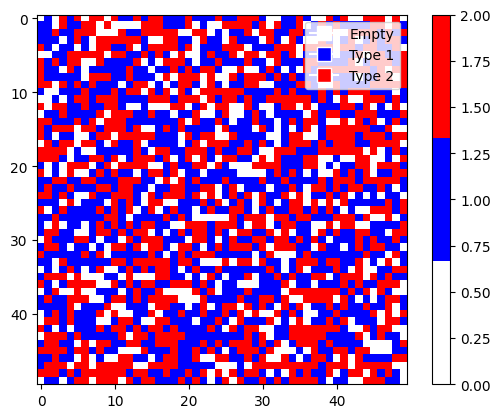

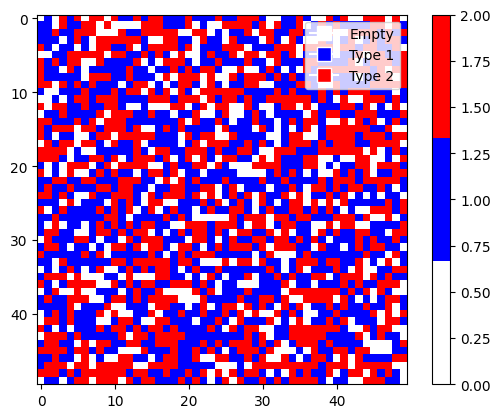

Animation saved to schelling_animation.mp4


In [2]:
model = SchellingModel(grid_size=50, n_agents=2000, n_types=2, similarity_threshold=0.5)
model.run()
model.create_animation(save_path='schelling_animation.mp4')

In [3]:
np.random.normal(20, 10)

35.11074474580498